In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [397]:
netflix_df = pd.read_csv('netflix_dataset.csv')

In [398]:
netflix_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [399]:
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Clean Data

In [401]:
netflix_df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [402]:
# Fill null values in specific columns... NaN -> Unknown
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')
netflix_df['country'] = netflix_df['country'].fillna('Unknown')
netflix_df['date_added'] = netflix_df['date_added'].fillna('Unknown')
netflix_df['rating'] = netflix_df['rating'].fillna('Unknown')
netflix_df['duration'] = netflix_df['duration'].fillna('Unknown')

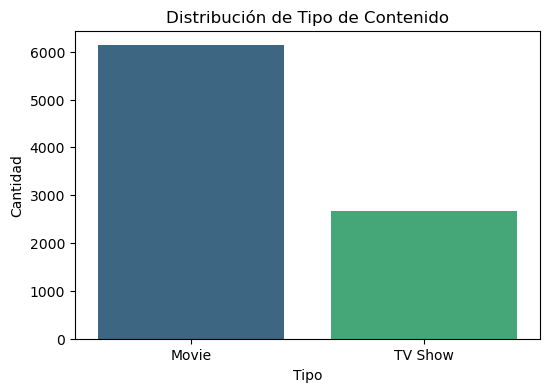

In [403]:
plt.figure(figsize=(6,4))
sns.countplot(x='type', hue='type', data=netflix_df, palette='viridis', legend=False)
plt.title('Distribución de Tipo de Contenido')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.show()